## Step 1. Import the data from the given .csv file (Google_Stock_Price_Train.csv Download Google_Stock_Price_Train.csv).

In [1]:
# Import the necessary  libraries
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


In [2]:
# Read the file
df_stock = pd.read_csv("Google_Stock_Price_Train.csv")

In [3]:
# Show some basic info on the df
df_stock.describe()

,Open,High,Low
count,1258.000000,1258.000000,1258.000000
mean,533.709833,537.880223,529.007409
std,151.904442,153.008811,150.552807
min,279.120000,281.210000,277.220000
25%,404.115000,406.765000,401.765000
50%,537.470000,540.750000,532.990000
75%,654.922500,662.587500,644.800000
max,816.680000,816.680000,805.140000


In [4]:
df_stock["Close"].describe()

count       1258
unique      1241
top       718.81
freq           2
Name: Close, dtype: object

In [5]:
# number of rows and cols
df_stock.shape

(1258, 6)

In [6]:
# List 3 rows of df
df_stock.head(3)

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"


In [7]:
# There are no null values
df_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


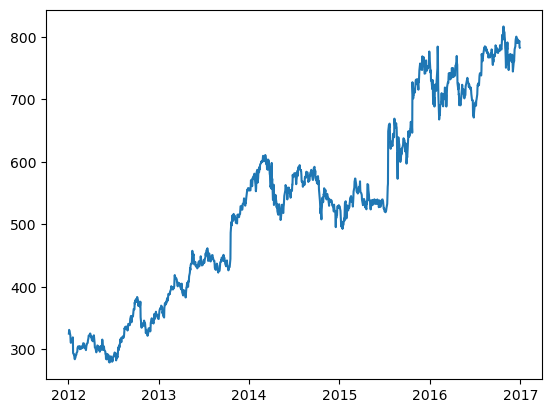

In [8]:
df_stock['Date'] = pd.to_datetime(df_stock['Date'])

plt.plot(df_stock['Date'], df_stock['Open'])

## Step 2. Preprocess the data as you see fit
## Step 3. Split into 80% train 20% prediction

In [9]:
# Perform our analysis on the 'Open' feature

# Create a copy so we dont receive any warnings later
price = df_stock[['Open']].copy()
# Number of rows and cols
print(price.shape)
# Look at few records
print(price.head(5))

# Assuming 'data' is your original DataFrame and you're creating 'price' as a slice of it
#price = df_stock[['Open']].copy()  # Creates a standalone copy

(1258, 1)
     Open
0  325.25
1  331.27
2  329.83
3  328.34
4  322.04


In [10]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0,1))
# Use .values.reshape(-1, 1) to transform the series into a 2D array suitable for the scaler
price['Open'] = scaler.fit_transform(price['Open'].values.reshape(-1,1))
print(price.head())
print(price.shape)

       Open
0  0.085814
1  0.097012
2  0.094334
3  0.091562
4  0.079842
(1258, 1)


In [11]:
# Split the data for training and validation
dataset = price.values

test_set_size = int(np.round(0.2*price.shape[0]))
train_set_size = price.shape[0] - test_set_size

print('The train size is ',train_set_size)
print('The test size is ',test_set_size)

train = dataset[0:train_set_size,:]
print('# rows used for training', train.shape)

test = dataset[train_set_size:,:]
print('# rows used for predidction',test.shape)

The train size is  1006
The test size is  252
# rows used for training (1006, 1)
# rows used for predidction (252, 1)


In [12]:
# Splitting the data for time forecast series
def split_data(stock, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    # convert to numpy for numerical operations and indexing
    data_raw = stock.to_numpy()
    data = []
    # Creates an overlapping sequence, each sequcne consist
    # of number of lookback number of consecutive data points
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    # Sequnce then organizes into 3 dimnesional array with
    # data, number of time steps, and features between train and test env
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [13]:
lookback = 60
x_train, y_train, x_test, y_test = split_data(price, lookback)

print('x_train.shape =', x_train.shape)
print('y_train.shape =', y_train.shape)
print('x_test.shape =', x_test.shape)
print('y_test.shape =', y_test.shape)


x_train.shape = (958, 59, 1)
y_train.shape = (958, 1)
x_test.shape = (240, 59, 1)
y_test.shape = (240, 1)


In [14]:
# convert to tensors

x_train = torch.from_numpy(x_train).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)

x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)


In [15]:
# Define variable and hyper parameters

# number of features of input data
input_dim = 1
# size of hidden layers, captures each cell and represents
# at each time step, captures complex relationship
# helps with risk of overfitting
hidden_dim = 64
# Number of LSTM layers stacked on each other,
# depth of network, each of layer takes
# sequence output by previous layer and passes
# output to next layer
num_layers = 2
# number of features of output data 
output_dim = 1
# number of training cycles
num_epochs = 500
# Learning rate
lr = 0.001

In [16]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        dropout=0.2
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        # Finally connected layer to output from output of LSMT layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Hidden state, gradients enabled forback propogation, followed by detach,
        # to prevent the gradient from being calculated with subsequent pass 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
          # cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        # The output of the last time step is passed through a fully connected 
        # layer to produce the final output.        
        out = self.fc(out[:, -1, :]) 
        return out

## Step 4. Train the model on the data


In [17]:
# Initialize the model, define hyperparameters
# Loss and optimizer

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [18]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

# Train the model
for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.29851776361465454
Epoch  1 MSE:  0.08627338707447052
Epoch  2 MSE:  0.35316336154937744
Epoch  3 MSE:  0.04878905415534973
Epoch  4 MSE:  0.09251607954502106
Epoch  5 MSE:  0.1186271607875824
Epoch  6 MSE:  0.125314399600029
Epoch  7 MSE:  0.11994747072458267
Epoch  8 MSE:  0.10675578564405441
Epoch  9 MSE:  0.08813341706991196
Epoch  10 MSE:  0.06648891419172287
Epoch  11 MSE:  0.04744574800133705
Epoch  12 MSE:  0.0463358536362648
Epoch  13 MSE:  0.06529112905263901
Epoch  14 MSE:  0.05992438271641731
Epoch  15 MSE:  0.04620177298784256
Epoch  16 MSE:  0.03975244611501694
Epoch  17 MSE:  0.03955020383000374
Epoch  18 MSE:  0.04139764606952667
Epoch  19 MSE:  0.04271719232201576
Epoch  20 MSE:  0.04240311682224274
Epoch  21 MSE:  0.04016360267996788
Epoch  22 MSE:  0.03616500645875931
Epoch  23 MSE:  0.030942244455218315
Epoch  24 MSE:  0.025554457679390907
Epoch  25 MSE:  0.022271201014518738
Epoch  26 MSE:  0.026383990421891212
Epoch  27 MSE:  0.02119438350200653
Ep

Epoch  217 MSE:  0.00046642430243082345
Epoch  218 MSE:  0.0004658204852603376
Epoch  219 MSE:  0.00046521949116140604
Epoch  220 MSE:  0.0004646213201340288
Epoch  221 MSE:  0.0004640259430743754
Epoch  222 MSE:  0.0004634333890862763
Epoch  223 MSE:  0.00046284348354674876
Epoch  224 MSE:  0.00046225611004047096
Epoch  225 MSE:  0.0004616714722942561
Epoch  226 MSE:  0.00046108925016596913
Epoch  227 MSE:  0.0004605096473824233
Epoch  228 MSE:  0.0004599324311129749
Epoch  229 MSE:  0.0004593577759806067
Epoch  230 MSE:  0.00045878547825850546
Epoch  231 MSE:  0.00045821539242751896
Epoch  232 MSE:  0.00045764766400679946
Epoch  233 MSE:  0.00045708223478868604
Epoch  234 MSE:  0.0004565190174616873
Epoch  235 MSE:  0.00045595807023346424
Epoch  236 MSE:  0.0004553991893772036
Epoch  237 MSE:  0.00045484252041205764
Epoch  238 MSE:  0.0004542877140920609
Epoch  239 MSE:  0.00045373509055934846
Epoch  240 MSE:  0.0004531844751909375
Epoch  241 MSE:  0.0004526358679868281
Epoch  242 MS

Epoch  426 MSE:  0.00037153679295443
Epoch  427 MSE:  0.0003712024772539735
Epoch  428 MSE:  0.00037086912197992206
Epoch  429 MSE:  0.0003705369308590889
Epoch  430 MSE:  0.0003702057583723217
Epoch  431 MSE:  0.000369875633623451
Epoch  432 MSE:  0.000369546702131629
Epoch  433 MSE:  0.0003692187019623816
Epoch  434 MSE:  0.000368891836842522
Epoch  435 MSE:  0.0003685659321490675
Epoch  436 MSE:  0.00036824122071266174
Epoch  437 MSE:  0.0003679173532873392
Epoch  438 MSE:  0.0003675945335999131
Epoch  439 MSE:  0.000367272732546553
Epoch  440 MSE:  0.00036695192102342844
Epoch  441 MSE:  0.00036663227365352213
Epoch  442 MSE:  0.00036631329567171633
Epoch  443 MSE:  0.00036599559825845063
Epoch  444 MSE:  0.0003656785993371159
Epoch  445 MSE:  0.0003653628227766603
Epoch  446 MSE:  0.0003650477738119662
Epoch  447 MSE:  0.0003647337725851685
Epoch  448 MSE:  0.0003644206444732845
Epoch  449 MSE:  0.00036410847678780556
Epoch  450 MSE:  0.00036379724042490125
Epoch  451 MSE:  0.0003

In [19]:
'''
As we scaled down the values of dataset using MinMaxScaler, we need to again reverse the 
transformation in order to get accurate predicted values on the graph hence , 
here we inverse the transform of both the predictions.
'''
actuals = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))
print(actuals.head())
preds = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
print(preds.head())

            0
0  324.799988
1  325.500000
2  324.660004
3  319.190002
4  321.500000
            0
0  321.690186
1  323.267883
2  324.666626
3  325.475647
4  324.596375


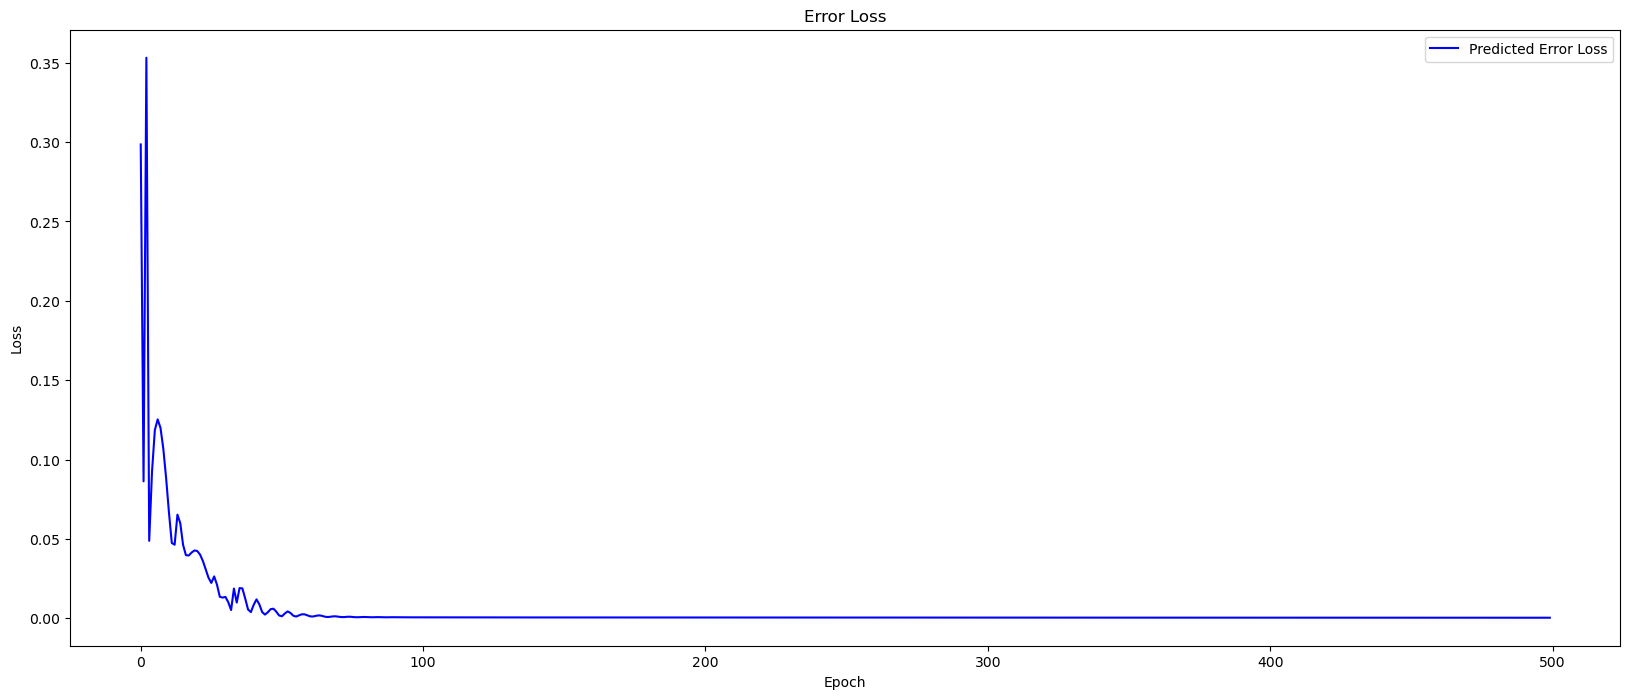

In [20]:
#Plot error loss
epochs = np.arange(num_epochs)
plt.figure(figsize=(20,8))
plt.plot(epochs, hist, color = 'blue', label = 'Predicted Error Loss')
plt.title('Error Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Step 5. Report on the results of your model

In [21]:
print(x_test.shape)
print(y_test.shape)

torch.Size([240, 59, 1])
(240, 1)


In [22]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())

y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

In [23]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 10.05 RMSE
Test Score: 12.44 RMSE


Here both the values calculated are very close i.e.; in difference is less than 2, which indicates that the model accuracy is good.

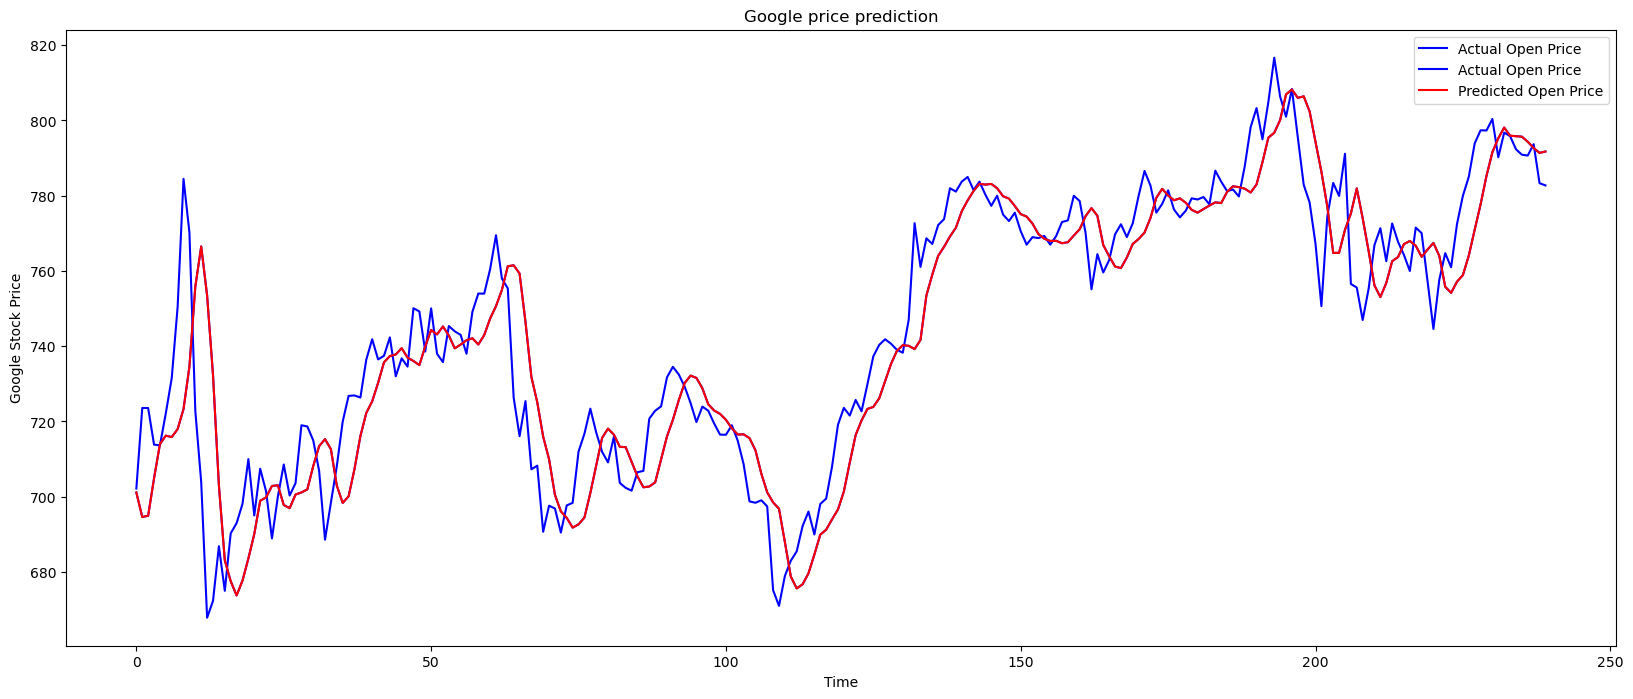

In [24]:
#Shift test predictions for plotting
original = scaler.inverse_transform(price['Open'].values.reshape(-1,1))
actuals = pd.DataFrame(original)
preds = pd.DataFrame(y_test_pred)
#print("Predicted Open")
#print(preds.head())

#Prepare actual open entries
aScalar = actuals[len(price) - len(preds):len(price)]
#print(len(aScalar))
#Reset indexes for actuals
aScalar = aScalar.reset_index(drop=True)

#Plot predictions/actuals close price for test entries
valid = aScalar
valid['Predictions'] = preds
plt.figure(figsize=(20,8))
plt.plot(valid, color = 'blue', label = 'Actual Open Price')
plt.plot(valid['Predictions'], color = 'red', label = 'Predicted Open Price')
plt.title('Google price prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()